In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
import random
import skops.io as sio
import itertools as it
from sklearn.metrics import top_k_accuracy_score, average_precision_score, log_loss, accuracy_score
from IPython.display import display, clear_output, HTML
import gc

## Classificação de imagens reais e falsas

### Dataset 
link do dataset: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB

Os dados são números inteiros de 0 a 255 representando o valor de cada pixel, para normalizar os dados precisamos apenas dividir todos os valores por 255

In [2]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3)) / 255
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3)) / 255
print(test_x.shape, train_x.shape)

(20000, 32, 32, 3) (100000, 32, 32, 3)


Os dados estão distribuídos de forma que a primeira metade dos dados faz parte da classe falsa e a segunda metade da classe real. Os vetores y são preenchidos com 0s e 1s de acordo com as classes

In [3]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


### Imagens do dataset
As imagens que compõem o dataset são imagens de aviões, automóveis, pássaros, cervos, gatos, cachorros, sapos, cavalos, navios e caminhões. Todas as imagens tem características diferentes não seguindo padrões aparentes

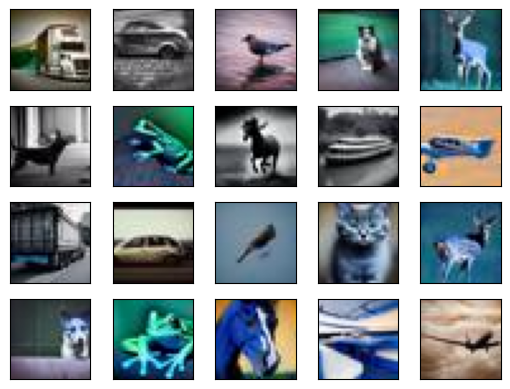

In [4]:
for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x[i-1])


In [5]:
def auxiliar_indexes(data_size, aux_data_size):
    aux_data_size = int(aux_data_size/2)
    half = int(data_size / 2)
    indexes = list(range(half-aux_data_size, half+aux_data_size))
    random.shuffle(indexes)
    return indexes


In [6]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

In [7]:
aux_test_i = auxiliar_indexes(len(flat_test_x), 400)
aux_train_i = auxiliar_indexes(len(flat_train_x), 2000)


### Rede Neural Convolucional(Cnn)

In [8]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy

In [9]:
cnn_model = Sequential()

cnn_model.add(Conv2D(128, 3, input_shape=(32,32,3)))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 3))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPool2D())

cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(2, activation="sigmoid"))

In [10]:
cnn_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [11]:
if os.path.exists('cnn_files/cnn_model'):
    cnn_model = load_model('cnn_files/cnn_model')
    with open('cnn_files/cnn_fit.txt', 'r') as f:
        print(f.read())
else:
    cnn_model.fit(train_x, train_y, epochs=5, use_multiprocessing=True, batch_size=64, validation_split=0.2)
    cnn_model.save("cnn_files/cnn_model")


Epoch 1/5
1250/1250 [==============================] - 640s 509ms/step - loss: 0.3115 - accuracy: 0.8638 - val_loss: 0.3730 - val_accuracy: 0.8370
Epoch 2/5
1250/1250 [==============================] - 610s 488ms/step - loss: 0.1942 - accuracy: 0.9226 - val_loss: 0.6428 - val_accuracy: 0.7273
Epoch 3/5
1250/1250 [==============================] - 596s 477ms/step - loss: 0.1600 - accuracy: 0.9370 - val_loss: 0.2730 - val_accuracy: 0.9044
Epoch 4/5
1250/1250 [==============================] - 673s 537ms/step - loss: 0.1307 - accuracy: 0.9491 - val_loss: 0.2077 - val_accuracy: 0.9222
Epoch 5/5
1250/1250 [==============================] - 407s 325ms/step - loss: 0.1088 - accuracy: 0.9589 - val_loss: 0.2444 - val_accuracy: 0.9194


In [12]:
cnn_model.evaluate(test_x, test_y, use_multiprocessing=True)

625/625 [==============================] - 61s 89ms/step - loss: 0.1736 - accuracy: 0.9395


[0.17361047863960266, 0.9394500255584717]

In [13]:
cnn_proba = cnn_model.predict(test_x, use_multiprocessing=True)

625/625 [==============================] - 50s 77ms/step


In [14]:
filters, bias = cnn_model.layers[0].get_weights()

#### Por que esses valores?

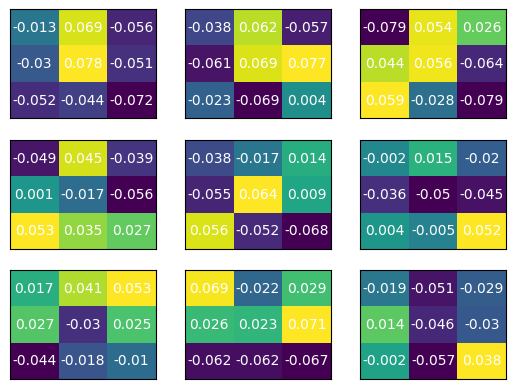

In [15]:
for i in range(1,10):
    plt.subplot(3,3,i)
    f = filters[:,:,0,i-1]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(f, aspect='auto', interpolation='nearest')

    for x in range(len(f)):
        for y in range(len(f[x])):
            text = plt.text(y,x, round(f[x][y], 3),
                   ha="center",va='center', color="w")


In [16]:
feature_maps = Sequential(layers=cnn_model.layers[:1]).predict(test_x[2:3])

1/1 [==============================] - 0s 120ms/step


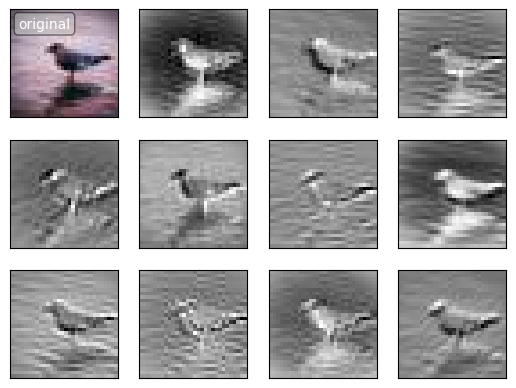

In [17]:
plt.subplot(3,4,1)
plt.xticks([])
plt.yticks([])
plt.imshow(test_x[2])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})

for i in range(2,13):
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0][:,:,i+11], cmap='gray')

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

In [19]:
knn_proba = sio.loads(sio.load("knn_files/knn_proba.skops"))
ann_proba = sio.loads(sio.load("ann_files/ann_proba.skops"))
tree_proba = sio.loads(sio.load("tree_files/tree_proba.skops"))

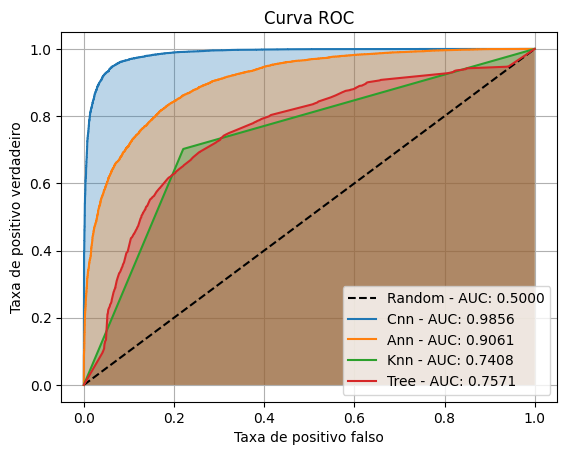

In [37]:
plt.plot([0,1], [0,1], '--', color='black', label='Random - AUC: 0.5000', zorder=4)
for proba, name in zip([cnn_proba, ann_proba,knn_proba, tree_proba], ['Cnn', 'Ann', 'Knn', 'Tree' ]):
    fpr, tpr, _ = roc_curve(test_y, proba.transpose()[0])
    auc = str(round(1 - roc_auc_score(test_y, proba.transpose()[0]), 4)).ljust(6, '0')
    plt.fill([*tpr, tpr[-1]], [*fpr, 0], alpha=0.3, zorder=3)
    plt.plot(tpr, fpr, label=f'{name} - AUC: {auc}', zorder=4)
    plt.legend(loc='lower right')
plt.ylabel('Taxa de positivo verdadeiro')
plt.xlabel('Taxa de positivo falso')
plt.title('Curva ROC')
plt.grid()


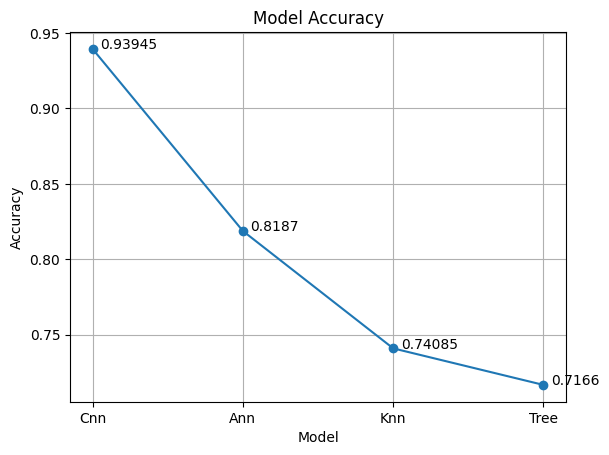

In [32]:
acc = []
for proba in [cnn_proba, ann_proba, knn_proba, tree_proba]:
    acc.append(accuracy_score(test_y, [np.argmax(x) for x in proba]))
names = ['Cnn', 'Ann', 'Knn', 'Tree']

plt.plot(names,acc, '-o')
for x, y, name in zip(range(len(acc)), acc, names):
    plt.text(x+0.05, y, y)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Accuracy')
plt.grid()
